# Regridding CMIP6
##### Here we regrid a user defined cmip6 grid to another user defined target grid. For this we use `xESMF`, `intake-esm`, `dask`, and `xarray`.
##### Initial benchmarking: 41 seconds/decade  downscale CESM2 to a ~12 km grid over CONUS

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import xsd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 
from xsd.pointwise_models import PointWiseDownscaler, QuantileMapper

In [2]:
# cluster = SLURMCluster(cores=2, memory='12GB', project='UCGD0006')
# cluster.adapt(minimum_cores=0, maximum_cores=30)
# client = Client(cluster)
# cluster = SLURMCluster(cores=36, memory='100GB', project='UCGD0006',
#                        processes=36)
# cluster.adapt(minimum=1*36, maximum=10*36)
from dask.diagnostics import ProgressBar

## Define temporal period of interest

In [3]:
t0 = '1980-01-01'
tf = '1980-12-31'

## Define target grid
##### This is the grid that we will interpolate CMIP6 data to. 

In [4]:
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
tgt_ds = cat['gmet_v2'].to_dask()
tgt_ds = tgt_ds.sel(time=slice(t0, tf))
tgt_grid = xr.Dataset({'lat': (['lat'], tgt_ds['lat']),
                     'lon': (['lon'], tgt_ds['lon'])})

## Retrieve CMIP6 data
##### This data will be regridded to the target grid.

In [5]:
# Querry CMIP6 data catalog for desired data
cat = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
#                  table_id = ['day'], variable_id = ['pr'], member_id = ['r2i1p1f1'])
                 table_id = ['day'], variable_id = ['pr'])
print(len(cat.df))

# Create dataset
train_ds = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1000}})
train_ds = train_ds['CMIP.NCAR.CESM2.historical.day.gn']['pr']
# train_ds = train_ds.sel(time=slice(t0, tf))
train_ds = train_ds.isel(time=slice(47450, 47815))
train_ds.data

170
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dask.array<getitem, shape=(10, 365, 192, 288), dtype=float32, chunksize=(1, 365, 192, 288), chunktype=numpy.ndarray>

## Regrid CMIP6 grid to target grid

In [6]:
regridder = xe.Regridder(train_ds, tgt_grid, 'bilinear')
regridder.clean_weight_file()
train_ds = regridder(train_ds)
train_ds.data
with ProgressBar():
    train_ds = train_ds.persist() # Applies regridding (no longer lazy!)

Create weight file: bilinear_192x288_224x464.nc
Remove file bilinear_192x288_224x464.nc
[########################################] | 100% Completed | 14.6s


## Unit Conversions

In [7]:
# # Currently the regirdded data is daily time resolution with units of kg/m^2/sec
# # Multiply by 86400 to transform to mm/day (the same as kg/m^2/day)
train_ds = train_ds * 86400

## Plot Regrided Data

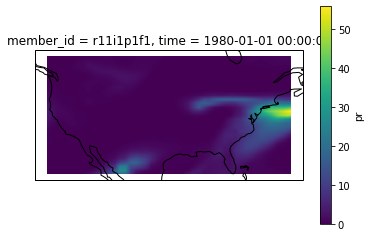

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
train_ds.isel(member_id=0, time=0).plot.pcolormesh(ax=ax);
ax.coastlines();

## Calculate Model Bias.
##### Subtract gridden mean 1980

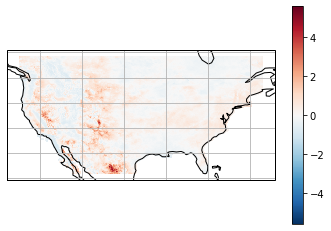

In [15]:
# Calculate model bias
train_mean = train_ds.mean(dim='time').mean(dim='member_id')
obs_mean = tgt_ds.mean(dim='time')
train_bias = train_mean - obs_mean['pcp']
train_bias_pct = train_bias / obs_mean['pcp']

# Plot model bias
ax = plt.axes(projection=ccrs.PlateCarree())
train_bias_pct.plot.pcolormesh(ax=ax);
ax.coastlines();
ax.gridlines()

## Now apply a statistical downscalling approach using `xsd`. Currently doesn't work :(

In [10]:
# Make an empy predicting function
class MyQM(QuantileMapper):
    def predict(self, X):
        pass

# Construct quantile mapping model and then apply on training and target datasets
qm = PointWiseDownscaler(model=MyQM, dim='time')
test = qm.fit(train_ds, tgt_ds['pcp'])

ValueError: indexes along dimension 'time' are not equal